In [68]:
import numpy as np
import astropy
from astropy.io import ascii
from astropy.table import Table
import scipy.linalg as la 
import pandas as pd     
import requests
import uncertainties

In [2]:
header = ["Exclusion Code",
            "D",
            "G",
            "Galaxy ID",
            "m-M",
            "err",
            "D (Mpc)",
            "Method",
            "REFCODE",
            "SN ID",
            "redshift (z)",
            "Hubble const.",
            "Adopted LMC modulus",
            "Date (Yr. - 1980)", 
            "Notes"]
ned_data = pd.read_csv("./NED30.5.1-D-17.1.2-20200415.csv", names=header, skiprows=13)

In [3]:
np.unique(ned_data['Method'])

array(['AGB', 'AGN time lag', 'B Stars', 'BCG', 'BL Lac Luminosity',
       'Black Hole', 'Blue Supergiant', 'Brightest Stars', 'CMD',
       'CO ring diameter', 'Carbon Stars', 'Cepheids', 'D-Sigma',
       'Delta Scuti', 'Diameter', 'Dwarf Ellipticals',
       'Dwarf Galaxy Diameter', 'Eclipsing Binary', 'FGLR', 'FP',
       'Faber-Jackson', 'G Lens', 'GC FP', 'GC K vs. (J-K)', 'GC SBF',
       'GC radius', 'GCLF', 'GRB', 'GeV TeV ratio',
       'Grav. Stability Gas. Disk', 'Grav. Wave',
       'H I + optical distribution', 'HII LF', 'HII region diameter',
       'Horizontal Branch', 'IRAS', 'Jet Proper Motion',
       'L(H{beta})-{sigma}', 'LSB galaxies', 'M Stars', 'Magnitude',
       'Maser', 'Mass Model', 'Miras', 'Novae', 'OB Stars',
       'Orbital Mech.', 'PAGB Stars', 'PNLF', 'Proper Motion',
       'Quasar spectrum', 'RR Lyrae', 'RSV Stars', 'RV Stars',
       'Radio Brightness', 'Red Clump', 'Ring Diameter',
       'S Doradus Stars', 'SBF', 'SGRB', 'SNII optical', 'SNII rad

In [46]:
def getGalInfo(galname):
    # res_headers = {
    #     'Content-type': 'application/json',
    # }
    res_data = {
        'json': '{"name":{"v": "%s"}}' % galname
    }
    res = requests.post('https://ned.ipac.caltech.edu/srs/ObjectLookup', data=res_data)
    return res.json()["Preferred"]

## Pick three methods to calculate the H_0 and then compare them for uncertainty analysis

Calculation method
$$v_r = cz$$
$$v_r = H_0 D$$
$$H_o = \frac{cz}{D}$$

In [55]:
bh_lum_mass_relation = ned_data[ned_data["Method"] == "Black Hole"]

In [81]:
trgb_method = ned_data[ned_data["Method"] == "TRGB"]

In [82]:
bh_host_info = {}
for index, row in bh_lum_mass_relation.iterrows():
    gal_info = getGalInfo(row["Galaxy ID"])
    redshift = gal_info["Redshift"]["Value"] 
    z_err = gal_info["Redshift"]["Uncertainty"]
    paper_reference = gal_info["Redshift"]["RefCode"]
    if redshift is None:
        print(row["Galaxy ID"], " redshift is null")
        continue
    bh_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)

omega Cen  redshift is null


In [100]:
trgb_host_info = {}
for index, row in trgb_method.iterrows():
    try:
        gal_info = getGalInfo(row["Galaxy ID"])
    except:
        print(row["Galaxy ID"], " no data")
        continue
    redshift = gal_info["Redshift"]["Value"] 
    z_err = gal_info["Redshift"]["Uncertainty"]
    paper_reference = gal_info["Redshift"]["RefCode"]
    if redshift is None:
        print(row["Galaxy ID"], " redshift is null")
        continue
    trgb_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)

GC 1  no data
Giant Southern Stream  no data
W-shelf, M31  no data
Scl-MM-Dw1  redshift is null
Scl-MM-Dw1  redshift is null
NGC 0253 Dwarf 2  no data
NGC 0253 Dwarf 2  no data
M33-EC1 star cluster  no data
Andromeda XXXIII  redshift is null
Fornax UFD1  redshift is null
CMa Dwarf  redshift is null
CMa Dwarf  redshift is null
KDG 050  redshift is null
d1005+68  no data
SDSS J115753.02+563649.0  redshift is null
SDSS J122620.08+123428.8  redshift is null
[C2006a] N dSph  redshift is null
[C2006a] N lsb10  redshift is null
Virgo UFD1  no data
[WCD2007] IGC-4  redshift is null
[CFC97] CEN 07  redshift is null
CenA-MM-Dw5  no data
CenA-MM-Dw4  no data
CenA-MM-Dw6  no data
CenA-MM-Dw7  no data
omega Cen  redshift is null
omega Cen  redshift is null
CenA-MM-Dw2  no data
CenA-MM-Dw2  no data
CenA-MM-Dw1  no data
CenA-MM-Dw1  no data
CenA-MM-Dw3  no data
CenA-MM-Dw3  no data
CenA-MM-Dw3  no data
CenA-MM-Dw3  no data
CenA-MM-Dw3  no data
CenA-MM-Dw9  no data
CenA-MM-Dw8  no data
MESSIER 101:[MV

In [87]:
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

not plot omega Cen


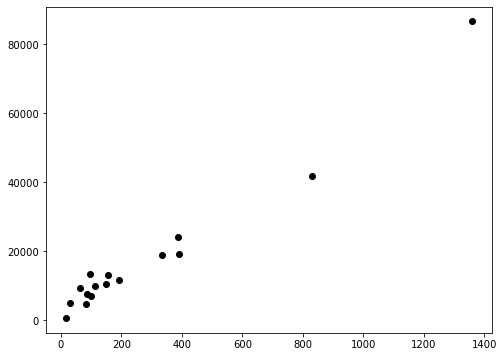

In [98]:
plt.figure(figsize=(8, 6))
for index, row in bh_lum_mass_relation.iterrows():
    # print(bh_host_info[row["Galaxy ID"]][0])
    if row["Galaxy ID"] not in bh_host_info.keys():
        print("not plot %s" % row["Galaxy ID"])
        continue
    plt.scatter(row["D (Mpc)"], const.c.to(u.km/u.s) * bh_host_info[row["Galaxy ID"]][0], c="k")

WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
WLM  rejected by 3 sigma cut
Andromeda XVIII  rejected by 3 sigma cut
Andromeda XVIII  rejected by 3 sigma cut
Andromeda XVIII  rejected by 3 sigma cut
Andromeda XVIII  rejected by 3 sigma cut
Andromeda XX  rejected by 3 sigma cut
Andromeda XX  rejected by 3 sigma cut
Andromeda XIX  rejected by 3 sigma cut
Andromeda XIX  rejected by 3 sigma cut
IC 0010  rejected by 3 sigma cut
IC 0010  rejected by 3 sigma cut
IC 0010  rejected by 3 sigma cut
IC 0010  rejected by 3 sigma cut

(0.0, 2000.0)

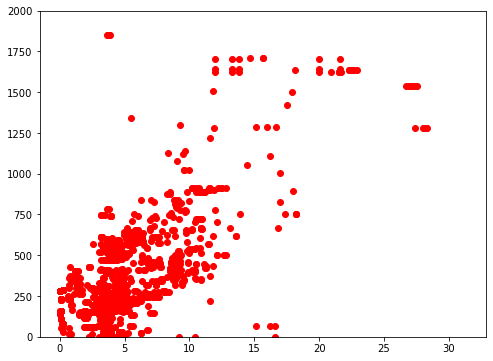

In [109]:
plt.figure(figsize=(8, 6))
trgb_d = []
trgb_vr = []
for index, row in trgb_method.iterrows():
    # print(bh_host_info[row["Galaxy ID"]][0])
    if row["Galaxy ID"] not in trgb_host_info.keys():
        print("not plot %s" % row["Galaxy ID"])
        continue
    # 3 sigma cut
    if trgb_host_info[row["Galaxy ID"]][0] < 3 * trgb_host_info[row["Galaxy ID"]][1]:
        print(row["Galaxy ID"], " rejected by 3 sigma cut")
        continue
    plt.scatter(row["D (Mpc)"], const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0], c="r")
    trgb_d.append(row["D (Mpc)"])
    trgb_vr.append(const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0])
plt.ylim([0, 2e3])

In [107]:
def hubble(d, H0):
    return H0 * d

In [108]:
from scipy.optimize import curve_fit

In [123]:
trgb_vr_data = [i.value for i in trgb_vr]
mask =  ((np.array(trgb_vr_data) < 2000))
popt, pcov = curve_fit(hubble, np.array(trgb_d)[mask], np.array(trgb_vr_data)[mask])

In [124]:
popt

array([65.53962396])

In [125]:
pcov

array([[0.9313899]])